In [1]:
import numpy as np

In [26]:
np.warnings.filterwarnings('ignore')

In [24]:
# %load utils.py
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline


############### Data Helpers ############### 
def load_data(csv_path):
    data = pd.read_csv(csv_path)
    data.rename(index=str,columns={ 'Unnamed: 0': 'Company'}, inplace=True)
    data.set_index('Company', inplace=True)
    data.columns = pd.to_datetime(data.columns)
    return data

def select_subset(dataframe,n_companies, n_days,total_companies):
    np.random.seed(47)
    rand_idx = np.random.choice(total_companies,n_companies, replace=False)
    subset = dataframe.iloc[rand_idx]
    return subset.iloc[:,:n_days]


############### Figures and Plotting ############### 
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, prefix='', tight_layout=False, fig_extension="png", resolution=300):
    
    dir_path = os.path.join(IMAGES_PATH, prefix)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    path = os.path.join(dir_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)    

def plot_clustering_results(X,n, labels, plot_title):
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

def save_clustering_results(X,n,labels, folder, plot_title, data_size='500x453'):
    current_path = os.path.join(folder,'{}_{}_clusters'.format(data_size,n))
    scaled_path = os.path.join(current_path, 'scaled')
    unscaled_path = os.path.join(current_path, 'unscaled')

    
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        save_fig(fig_id='clust_{}_{}'.format(label, data_size), prefix=unscaled_path, tight_layout=False, resolution=100)
        
        
    value_range = get_value_range(X)
    for label in np.unique(labels):
        X.iloc[labels == label].T.plot(figsize=(16,8),ylim=value_range,grid=True)
        plt.title(plot_title)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        save_fig(fig_id='clust_{}_{}'.format(label,data_size), prefix=scaled_path, tight_layout=False, resolution=100)
        
          
    clustered_df = pd.DataFrame(index=X.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    clustered_df.to_csv(os.path.join(IMAGES_PATH, current_path + '/labels.csv'))

    
    
def get_value_range(dataframe):
    minValue = dataframe.T.describe().loc['min'].min()
    maxValue = dataframe.T.describe().loc['max'].max()
    return (minValue, maxValue)
    

############### Validation Helpers ############### 

from sklearn.preprocessing import MinMaxScaler
import warnings

def scale_scores(score_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = MinMaxScaler()
        scaled_df = score_df.copy()
        scaled_df[scaled_df.columns] = scaler.fit_transform(score_df)
        return scaled_df

def plot_scores(score_df):
    scaled_df = scaled_scores(score_df)
    ax = scaled_df.plot(figsize=(16,8), x_compat=True, grid=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(scaled_df.index.max()))

def calc_combined_index(score_df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = MinMaxScaler()
        scaled_df = score_df.copy()
        scaled_df[scaled_df.columns] = scaler.fit_transform(scaled_df)

        return scaled_df.calinski + scaled_df.silhuette + ( -1* scaled_df.davis)


In [3]:
from ipynb.fs.defs.PortfolioSelection import create_portfolio

Stock Prices

In [4]:
snp500 = pd.read_csv('../datasets/sp500/sp500.csv', index_col='Date')
snp500.index= pd.to_datetime(snp500.index)

snp500_validation = pd.read_csv('../datasets/sp500/sp500validation.csv', index_col='Date')
snp500_validation.index= pd.to_datetime(snp500_validation.index)

In [5]:
ipc_df = load_data('../initial_pct_change.csv')

In [6]:
ipc_df_100 = select_subset(ipc_df, 100, 453, ipc_df.shape[0])

# Pearson Correlation

In [7]:
X = ipc_df.copy()
X_100 = ipc_df_100.copy()

In [8]:
X_corr = X.T.corr(min_periods=10)
X_100_corr = X_100.T.corr(min_periods=10)

### Correlation To Distance:


1. Dissimilarity = 1 - Correlation
1. Dissimilarity = (1 - Correlation)/2  -> As the above but scaled
1. Dissimilarity = 1 - Abs(Correlation) -> Negatively correlated are still correlated so group them in 1 cluster

[source](http://research.stowers.org/mcm/efg/R/Visualization/cor-cluster/index.htm)


In [9]:
X_dist = 1 - X_corr
X_100_dist = 1 - X_100_corr

# Clustering 

In [10]:
from sklearn import metrics
from sklearn.cluster import *

## Agglomerative Clustering

### Fine-Tuning

In [49]:
min_clusters = 4
max_clusters = 100 if len(X.index) > 100 else len(X.index) -1

linkage = 'average'

ag_corr_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis'])
ag_corr_score.index.name = 'n_clusters'

In [50]:
# curr_data = X.copy()
# curr_dist = X_dist.copy()
# data_size = '500x453'

curr_data = X_100.copy()
curr_dist = X_100_dist.copy()
data_size = '100x453'

for n in range(min_clusters, max_clusters):
    ag = AgglomerativeClustering(n_clusters=n,affinity='precomputed', linkage=linkage)
    ag.fit(curr_dist)
    
    sil = metrics.silhouette_score(curr_data,ag.labels_)
    calinski = metrics.calinski_harabaz_score(curr_data,ag.labels_)
    davis = metrics.davies_bouldin_score(curr_data, ag.labels_)
    
    ag_corr_score.loc[n] = [sil, calinski, davis]

In [51]:
scale_scores(ag_corr_score).plot()
comb_score = calc_combined_index(ag_corr_score)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')


# n = min_clusters
# while n < max_clusters:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  {}'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

handpicked = [4,8,18,36]
for n in handpicked:
    plt.plot(n, comb_score.loc[n], 'ro')
    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores {}, ag {} linkage, pearson corr'.format(data_size,linkage));
# save_fig('scores_{}_{}_pearson'.format(data_size,linkage), prefix='Agglomerative/Correlation/{}-linkage'.format(linkage))

### Validation

In [52]:
print('Scores {} ag {} linkage, pearson corr'.format(data_size,linkage))
print()
ag_corr_score.loc[handpicked]

Scores 100x453 ag average linkage, pearson corr



silhuette calinski     davis
n_clusters                              
4            0.017033  14.4094   1.52208
8          -0.0686922  8.63388   1.51017
18           -0.15315  3.49311   1.14202
36          -0.169884  2.31706  0.883316

### Visualisation

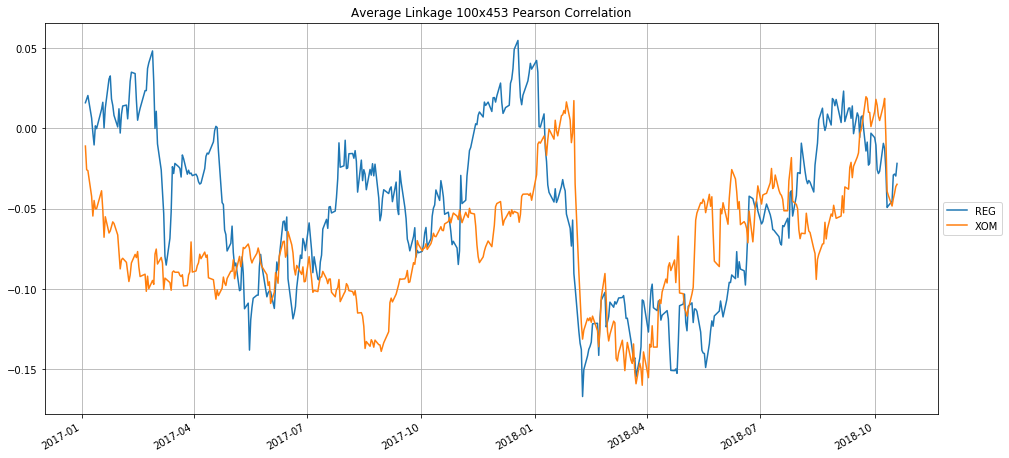

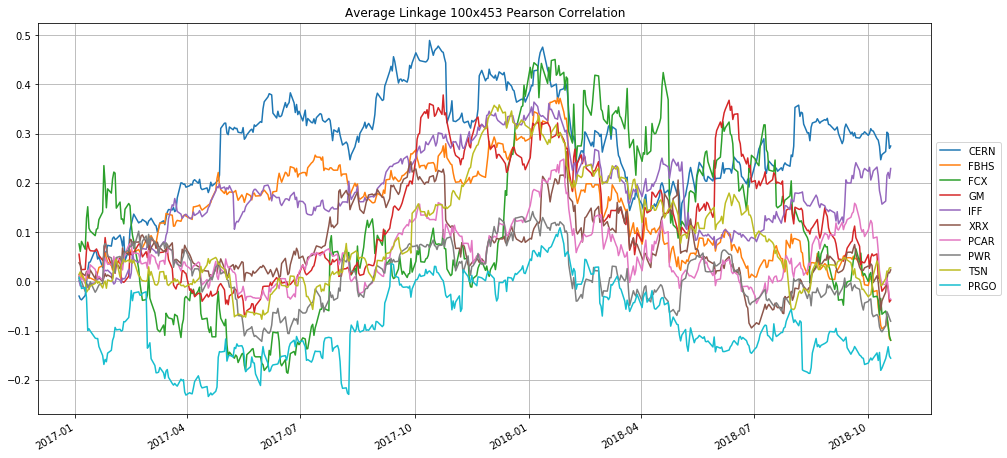

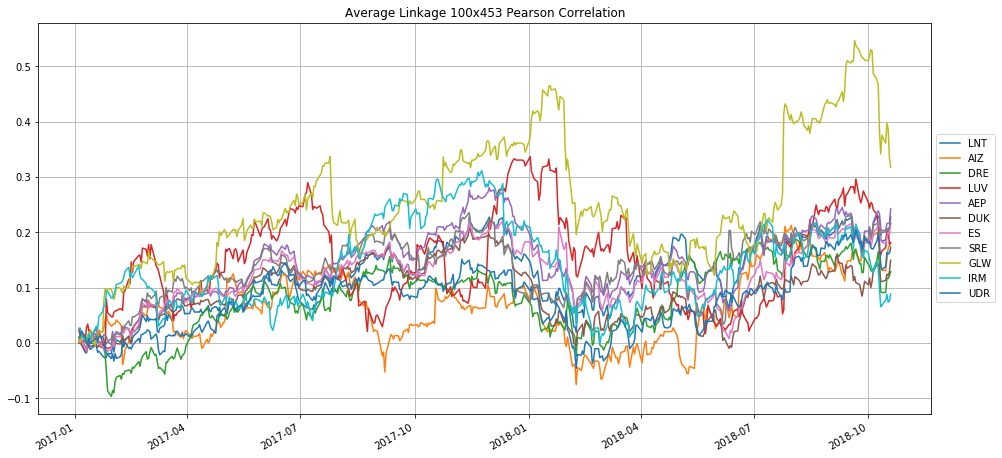

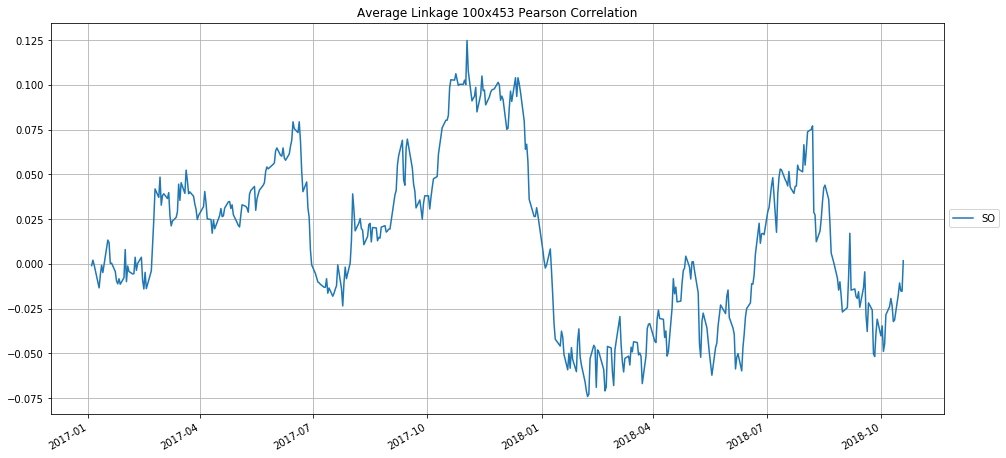

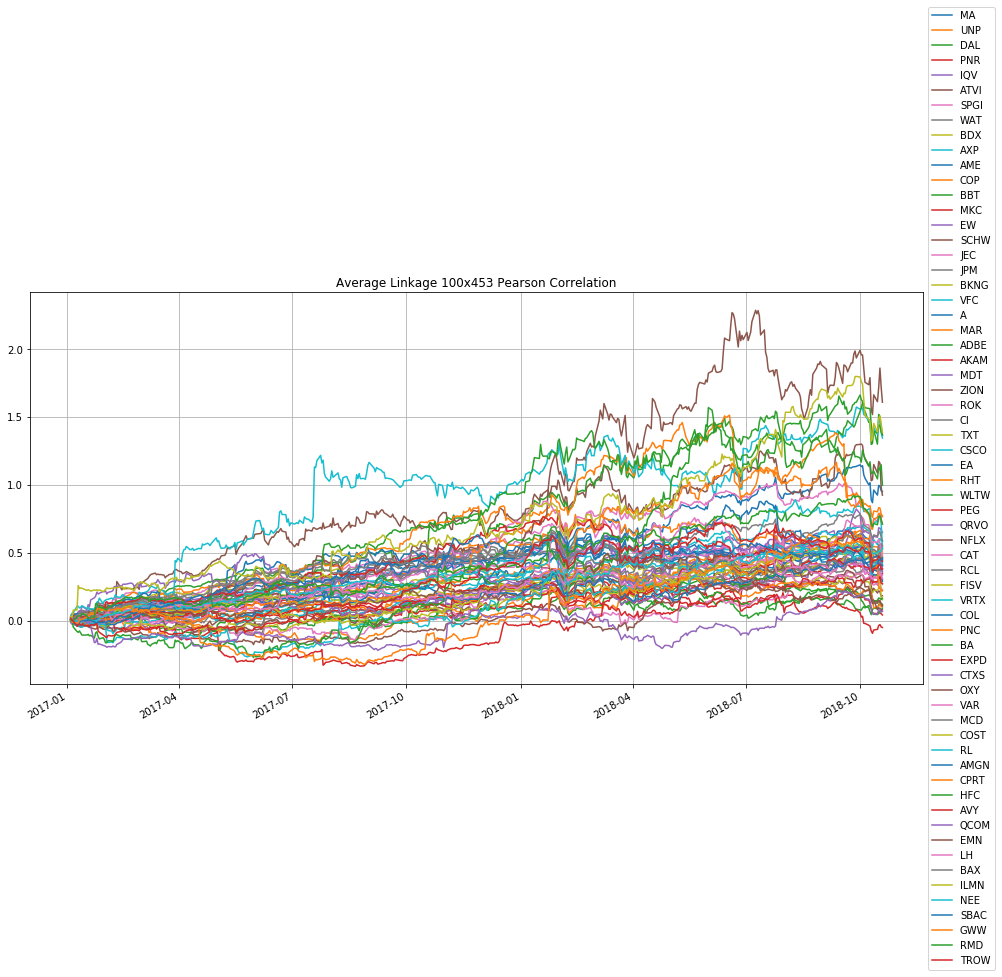

In [53]:
n = 8
ag = AgglomerativeClustering(n_clusters=n,affinity='precomputed', linkage=linkage)
labels = ag.fit_predict(curr_dist)
plot_clustering_results(curr_data,n,labels,'{} Linkage {} Pearson Correlation'.format(linkage.title(), data_size))

### Portfolio Creation

BA       AEP  CERN       CMG           WBA           REG  \
Allocation  0.569023  0.412913   0.0  0.018064  9.082904e-17  1.734999e-16   

            MYL            SO  
Allocation  0.0  7.616520e-18

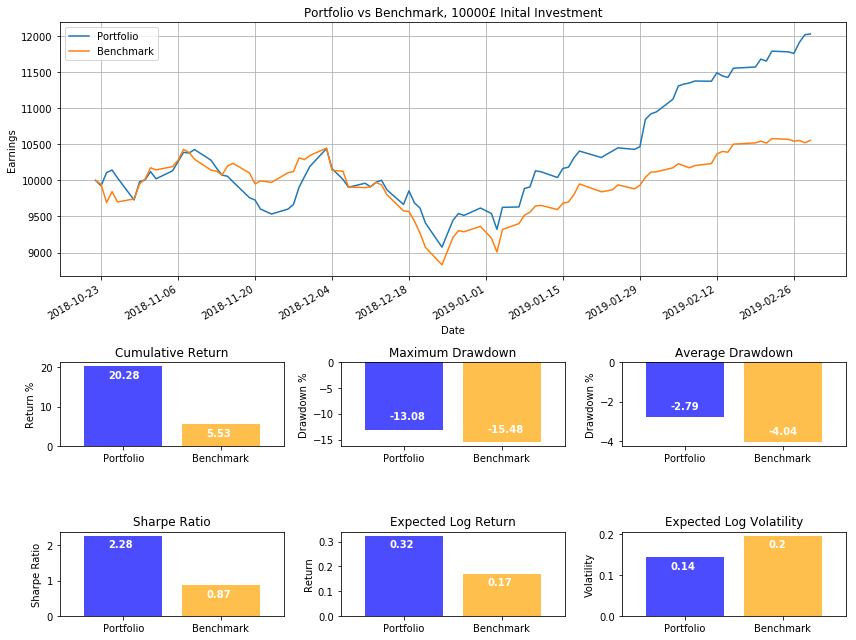

In [54]:
clustered_df = pd.DataFrame(index=curr_data.index, data=labels, columns=['Cluster'])
clustered_df.index.set_names('company')
validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
allocation.T

### Recording the results

In [ ]:
for n in handpicked:
    ag = AgglomerativeClustering(n_clusters=n,affinity='precomputed', linkage=linkage)
    labels = ag.fit_predict(curr_dist)
    folder = os.path.join('Agglomerative', 'Correlation','{}-linkage'.format(linkage))
    save_clustering_results(curr_data,
                            n,
                            labels,
                            folder,
                            '{} Linkage {} Pearson Correlation'.format(linkage.title(), data_size),
                            data_size=data_size
                           )

In [ ]:
handpicked = [4,8,18,36]

In [ ]:
data_size = '100x453'
# data_size = '500x453'
for n in handpicked:
    ag = AgglomerativeClustering(n_clusters=n,affinity='precomputed', linkage=linkage)
    labels = ag.fit_predict(curr_dist)
    clustered_df = pd.DataFrame(index=curr_data.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    folder = os.path.join('Agglomerative', 'Correlation','{}-linkage'.format(linkage), '{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'Agglomerative Clustering {} Linkage'.format(linkage.title()),
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Pearson Correlation', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
    

# KMediods Clustering

In [ ]:
import random
from past.builtins import xrange


def transform_labels(labels_by_clusters, X):
    labels = np.empty_like(X.index)
    for label in labels_by_clusters:
        labels[labels_by_clusters[label]] = label
        
    return labels

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [ ]:
curr_data = X.copy()
curr_dist = X_dist.copy().values
# curr_data = X_100.copy()
# curr_dist = X_100_dist.copy().values

min_clusters = 5
max_clusters = 100 if len(curr_data.index) > 100 else len(curr_data.index) -1

kmediods_score = pd.DataFrame(index=np.arange(min_clusters, max_clusters), columns=['silhuette', 'calinski', 'davis'])
kmediods_score.index.name = 'n_clusters'

In [ ]:
for n in range(min_clusters, max_clusters):
    _, C = kMedoids(curr_dist, n)
    labels = transform_labels(C,curr_data)

    sil = metrics.silhouette_score(curr_data,labels)
    calinski = metrics.calinski_harabaz_score(curr_data,labels)
    davis = metrics.davies_bouldin_score(curr_data,labels);
        
    kmediods_score.loc[n] = [sil, calinski, davis]

In [ ]:
scale_scores(kmediods_score).plot(alpha=0.5)
comb_score = calc_combined_index(kmediods_score)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')

# n = min_clusters
# while n < max_clusters:
#     n_with_max_score= comb_score.loc[n:n+5].idxmax()
    
#     plt.plot(n_with_max_score, comb_score.loc[n_with_max_score], 'ro')
#     plt.annotate('  local max {} clusters'.format(n_with_max_score),
#                  xy=(n_with_max_score, comb_score.loc[n_with_max_score]))
    
#     n = n+5

hand_picked_choise = [7,13,18,21,25]
for n in hand_picked_choise:    
    plt.plot(n, comb_score.loc[n], 'ro')
    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores 500x453, Kmediods Pearson Correlation')
save_fig('scores_500x453_kmediods_pearson', prefix='KMediods/Correlation/')


In [ ]:
print('Scores 500x453 KMediods Pearson Correlation')
print()
print(kmediods_score.loc[hand_picked_choise])
print()
print()
print('normalized')
print(scale_scores(kmediods_score).loc[hand_picked_choise])

In [ ]:
for n in hand_picked_choise:
    M, C = kMedoids(curr_dist, n)
    labels = transform_labels(C,curr_data)
    save_clustering_results(curr_data,
                            n,
                            labels,
                            'KMediods',
                            'KMediods 500 companies 2 Years Pearson',
                            data_size='500x453'
                           )



In [ ]:
handpicked = [7,13,18,21,25]

In [ ]:
# data_size = '100x453'
data_size = '500x453'
for n in handpicked:
    M, C = kMedoids(curr_dist, n)
    labels = transform_labels(C,curr_data)
   
    clustered_df = pd.DataFrame(index=curr_data.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500, validation_set, clustered_df)
    
    folder = os.path.join('KMediods', 'Correlation','{}_{}_clusters'.format(data_size,n))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), validation_set.shape[1]]
    stats['Algorithm'] = [
        'KMediods',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Pearson Correlation', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
    

## Affinity Propagation

In [ ]:
# curr_data = X.copy()
# curr_dist = X_dist.copy()
curr_data = X_100.copy()
curr_dist = X_100_dist.copy()

In [ ]:
ap_score = pd.DataFrame(columns=['silhuette', 'calinski', 'davis', 'damping'])
ap_score.index.name = 'n_clusters'

for damping in np.arange(0.5, 1, 0.01):
    ap = AffinityPropagation(damping=damping,affinity='precomputed')
    ap.fit(curr_dist)
    labels = ap.labels_

    sil = metrics.silhouette_score(curr_data,labels)
    calinski = metrics.calinski_harabaz_score(curr_data,labels)
    davis = metrics.davies_bouldin_score(curr_data,labels);

    n_clusters = len(np.unique(ap.labels_))
    if n_clusters not in ap_score.index or sil > ap_score.loc[n_clusters]['silhuette']:
        ap_score.loc[n_clusters] = [sil, calinski, davis, damping]

In [ ]:
ap_score

In [ ]:
print('Scores 100x453 Affinity Propagation Pearson Correlation')
print()
print(ap_score)

In [ ]:
for damping in ap_score['damping'].values:
    ap = AffinityPropagation(damping=damping,affinity='precomputed')
    labels = ap.fit_predict(curr_dist)
    folder = os.path.join('AffinityPropagation', 'Correlation')
    n_clusters = len(np.unique(labels))
    save_clustering_results(curr_data,
                            n_clusters, 
                            labels, 
                            folder,
                            'Affinity Propagation damping={} DTW, 100 companies 2 Years'.format(damping),
                            data_size="100x453")

In [ ]:
data_size = '100x453'
# data_size = '500x453'
for damping in ap_score['damping'].values:
    ap = AffinityPropagation(damping=damping,affinity='precomputed')
    labels = ap.fit_predict(curr_dist)
    
    clustered_df = pd.DataFrame(index=curr_data.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    n_clusters = len(np.unique(labels))
    
    folder = os.path.join('AffinityPropagation', 'Correlation', '{}_{}_clusters'.format(data_size,n_clusters))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n_clusters,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'Affinity Propagation',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Correlation', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n_clusters, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
    

## HDBSCAN

In [ ]:
import hdbscan

In [ ]:
# curr_data = X.copy()
# curr_dist = X_dist.copy()
curr_data = X_100.copy()
curr_dist = X_100_dist.copy()

In [ ]:
hdb_score = pd.DataFrame(columns=['silhuette', 'calinski', 'davis', 'min_samples', 'min_cluster_size', 'selection_method'])
hdb_score.index.name = 'n_clusters'

cluster_selection_methods = ['eom','leaf']

for selection_method in cluster_selection_methods:
    for min_samples in range(1, 30):
        for min_c_size in range(2, 70):
            hdb = hdbscan.HDBSCAN(min_cluster_size=min_c_size,
                                  min_samples=min_samples,
                                  cluster_selection_method=selection_method,
                                  metric='precomputed')
            labels  = hdb.fit_predict(curr_dist)
            n_clusters = len(np.unique(labels))

            try:
                sil = metrics.silhouette_score(curr_data,labels)
                calinski = metrics.calinski_harabaz_score(curr_data,labels)
                davis = metrics.davies_bouldin_score(curr_data,labels);

                if n_clusters not in hdb_score.index or sil > hdb_score.loc[n_clusters]['silhuette']:
                    hdb_score.loc[n_clusters] = [sil, calinski, davis, min_samples, min_c_size, selection_method]

            except:
                break

In [ ]:
hdb_score.sort_index(inplace=True)

In [ ]:
hdb_score

In [ ]:
hdb_score_indices = hdb_score[['silhuette', 'calinski', 'davis']]
scale_scores(hdb_score_indices).plot(alpha=0.5)
comb_score = calc_combined_index(hdb_score_indices)
comb_score.plot(figsize=(16,8), x_compat=True, grid=True, label='combined', legend=True, ls='--')


hand_picked_choise = [6]
for n in hand_picked_choise:    
    plt.plot(n, comb_score.loc[n], 'ro')

    plt.annotate('  {}'.format(n),
                 xy=(n, comb_score.loc[n]))
    
plt.title('Scores 100x453 HDBSCAN Pearson Correlation')
save_fig('scores_100x453_hdbscan_corr', prefix='Hdbscan/Correlation')

In [ ]:
print('Scores 100x453 HDBSCAN Pearson Correlation')
hdb_score.loc[hand_picked_choise]

In [ ]:
for index, model in hdb_score.loc[hand_picked_choise].iterrows():
    min_samples= model['min_samples']
    min_cluster_size=model['min_cluster_size']
    selection_method=model['selection_method']
    hdb = hdbscan.HDBSCAN(min_samples=min_samples,
                          min_cluster_size=min_cluster_size, 
                          cluster_selection_method=selection_method,
                          metric='precomputed')
    labels = hdb.fit_predict(curr_dist)

    folder = os.path.join('Hdbscan', 'Correlation')
    n_clusters = len(np.unique(labels))
    save_clustering_results(curr_data,
                            n_clusters, 
                            labels, 
                            folder,
                            'Hdbscan min_samples={}, min_c_size={}, selection_method={},DTW 100 companies 2 Years'.format(min_samples,min_cluster_size,selection_method),
                            data_size="100x453")

In [ ]:
data_size='100x453'
# data_size='500x453'
for index, model in hdb_score.loc[hand_picked_choise].iterrows():
    min_samples= model['min_samples']
    min_cluster_size = model['min_cluster_size']
    selection_method = model['selection_method']
    hdb = hdbscan.HDBSCAN(min_samples=min_samples,
                          min_cluster_size=min_cluster_size, 
                          cluster_selection_method=selection_method,
                          metric='precomputed')
    labels = hdb.fit_predict(curr_dist)
    
      
    clustered_df = pd.DataFrame(index=curr_data.index, data=labels, columns=['Cluster'])
    clustered_df.index.set_names('company')
    validation_set = snp500_validation[snp500_validation.columns.intersection(clustered_df.index)]
    allocation, stats =  create_portfolio(snp500,validation_set , clustered_df)
    
    n_clusters = len(np.unique(labels))
     
    folder = os.path.join('Hdbscan', 'Correlation', '{}_{}_clusters'.format(data_size,n_clusters))
    save_fig(fig_id='portfolio_{}_clusters_{}'.format(n_clusters,data_size), prefix=folder, tight_layout=False, resolution=300)
    
    stats['Num of Portfolio Companies'] = [(allocation['Allocation'] > 0).sum(), len(validation_set.columns)]
    stats['Algorithm'] = [
        'HDBSCAN',
        'Equal Allocation of S&P500'
    ]
    stats['Distance Metric'] = ['Pearson Correlation', np.nan]
    stats['Data Size'] = data_size
    stats['Number of clusters'] = [n_clusters, np.nan]
    
    allocation.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-allocation.csv'))
    stats.to_csv(os.path.join(IMAGES_PATH,folder, 'portfolio-stats.csv'))
    